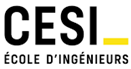
# <center><b><u>Livrable final, implémentation et exploitation, Algorithme Genetic :</u></b> </center>

### <u><b>Groupe :</b></u>
- BARRY Mamadou
- SADOWSKI Yann
- RAMBAUT Anthony
- VICINI Alexandre
- ALLIAS Gautier

FISA A3 INFO Pau

### <u><b>Données nécessaire au fonctionnement de l'algorithme :</b></u>
Les données que notre algorithme a besoin pour fonctionner peuvent provenir de 2 sources : 
- une génération automatique et aléatoire de points au sein d'un plan en deux dimensions 
- la lecture des données depuis un fichier .tsp qui suit le formalisme suivant : 

    NAME : filename<br>
    COMMENT : Rattled grid (Pulleyblank)<br>
    TYPE : TSP<br>
    DIMENSION : n<br>
    EDGE_WEIGHT_TYPE : EUC_2D<br>
    NODE_COORD_SECTION<br>
      1  6  4<br>
      2 15 15<br>
      n xn yn<br>
    EOF


### <u><b>Plan d'experience : </b></u>
1. Définir les objectifs de l'expérience :
    - Le plus petit temps d'éxécution
    - le poids le plus petit
    - une solution de bonne qualité -> une bonne répartition des villes entre les véhicules<br><br>

2. Choix des instances du problème : 
    - Une instance du rat99 et des instances pré-générées de 2 000, 4 000, 6 000 et 8 000 villes
        -> Utilisées pour les comparatifs
    - Une génération automatique de villes dans un plan en 2 dimensions 
        -> Utilisé pour montrer le fonctionnement de l'algorithme<br><br>
        
3. Approche : 
    - On va exécuter l'algorithme avec Rat99 en faisant évoluer le nombre de camions(2, 3, 5 et 7 camioms)
        -> Mesure du poids maximum, minimum et total
        -> Mesure du temps d'exécution
    - On va exécuter l'algorithme avec des instances de 2 000, 4 000, 6 000 et 8 000 villes
        -> Mesure de l'évolution du temps d'exécution en fonction du nombre de villes

Pour les étapes suivantes de notre plan d'experience : 

4. Conception de l'experience 
5. Mise en oeuvre et exécution de l'experience
6. Analyse
7. Interprétation 

Elles sont réparties dans la suite de ce notebook

### <u><b>Fonctionnement de l'algorithme :</b></u>
Voici l'algorithme de façon simplifié : <br>
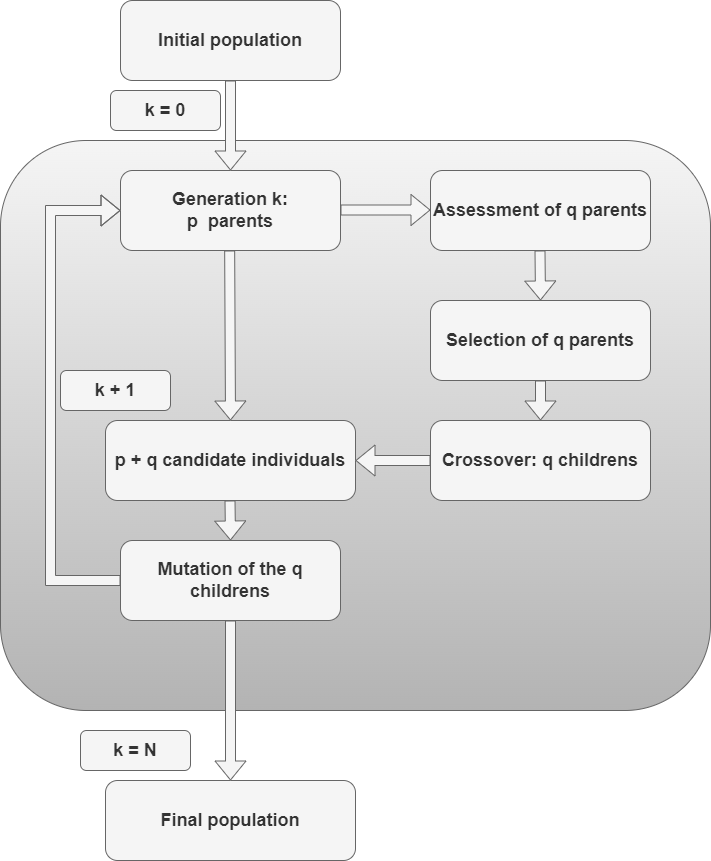

### <u><b>Implémentation de l'algorithme :</b></u>
Import des nos bibliothèques :

In [1]:
import random
import numpy as np
import datetime
import matplotlib.pyplot as plt
import itertools
import collections 
from copy import deepcopy


Nos fonctions :

In [2]:
# glouton function for my population
def glouton(city_distances,  nbrCamions):
    
        cities = list(city_distances.keys())
        
        # Initialize the truck to the starting city
        individual = [[cities[0]] for _ in range(nbrCamions)]
        
        # Create a copy of the cities to visit
        cities_copy = cities[1:]  

        # Assign cities to each truck until there are none left
        while cities_copy:
            for i in range(nbrCamions):
                
                # if there are still cities to assign
                if cities_copy:  
                    current_city = individual[i][-1]
                    
                    nearest_city = min(cities_copy, key=lambda city: city_distances[current_city][city])
                    
                    individual[i].append(nearest_city)
                    
                    cities_copy.remove(nearest_city)

        # Add the departure city at the end of each route
        for i in range(nbrCamions):
            individual[i].append(cities[0])

        return individual
    
def glouton_rdm(city_distances,  nbrCamions):
    
    cities = list(city_distances.keys())
    
    # Initialize the truck to the starting city
    individual = [[cities[0]] for _ in range(nbrCamions)]
    
    # Create a copy of the cities to visit
    cities_copy = cities[1:]  

    # Assign cities to each truck until there are none left
    while cities_copy:
        for i in range(nbrCamions):
            # if there are at least two cities left to assign
            if len(cities_copy) >= 2:  
                current_city = individual[i][-1]
                
                nearest_cities = sorted(cities_copy, key=lambda city: city_distances[current_city][city])[:2]
                
                individual[i].extend(nearest_cities)
                
                cities_copy.remove(nearest_cities[0])
                cities_copy.remove(nearest_cities[1])
                
            # if there is a city left to assign
            elif cities_copy:  
                current_city = individual[i][-1]
                nearest_city = min(cities_copy, key=lambda city: city_distances[current_city][city])
                individual[i].append(nearest_city)
                cities_copy.remove(nearest_city)

    # Add the departure city at the end of each route
    for i in range(nbrCamions):
        individual[i].append(cities[0])

    return individual

def glouton_diffStart(city_distances, nbrCamions):
    # Initialize the truck to the starting city
    cities = list(city_distances.keys())
    
    individual = [[cities[0]] for _ in range(nbrCamions)]
    
    # Create a copy of the cities to visit
    cities_copy = cities[1:]  

    # Assign a second different city to each truck
    # Choose nbrTrucks different cities
    second_cities = random.sample(cities_copy, nbrCamions)
      
    for i in range(nbrCamions):
        individual[i].append(second_cities[i])
        cities_copy.remove(second_cities[i])

    # Assign cities to each truck until there are none left
    while cities_copy:
        for i in range(nbrCamions):
            # if there are still cities to assign
            if cities_copy:  
                current_city = individual[i][-1]
                
                # Get the three nearest cities
                nearest_cities = sorted(cities_copy, key=lambda city: city_distances[current_city][city])[:3]
                
                # Choose a city randomly among the three closest
                chosen_city = random.choice(nearest_cities)
                
                individual[i].append(chosen_city)
                cities_copy.remove(chosen_city)

    # Add the departure city at the end of each route
    for i in range(nbrCamions):
        individual[i].append(cities[0])

    return individual



In [3]:
# On the sum distance
def calculate_fitness_sum(solution, city_distances):
    
    total_distance = []
    
    for truck_route in solution:
        distance_truck =0   
        num_cities = len(truck_route)-1
        
        for i in range(num_cities):
            current_city = truck_route[i]
            next_city = truck_route[(i + 1)]
            distance_truck += city_distances[current_city][next_city]
            
        total_distance.append(distance_truck)
    
    return sum(total_distance)
    
# Fitness on the sum of distance and the difference between max and min
def calculate_fitness_2(solution, city_distances):
    
    total_distance = []
    
    for truck_route in solution:
        distance_truck =0   
        num_cities = len(truck_route)-1
        
        for i in range(num_cities):
            current_city = truck_route[i]
            next_city = truck_route[(i + 1)]
            distance_truck += city_distances[current_city][next_city]
            
        total_distance.append(distance_truck)
        

    return (sum(total_distance), max(total_distance) - min(total_distance))



In [4]:
def selection(fitness_scores):
    
    # Sort the indices according to their maximum fitness, then by their total fitness in case of a tie
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda k: (fitness_scores[k][0], fitness_scores[k][1]))
    
    return sorted_indices

In [5]:
#2 linked functions to find and modify duplicates following a crossover
def get_duplicates(child):
    
    # Create a dictionary to count occurrences of cities        
    city_count = collections.defaultdict(int)  
    duplicates = []
    
    for route in child:
        # Ignore the first and last city of each route
        for city in route[1:-1]:  
            city_count[city] += 1

    for city, count in city_count.items():
        if count > 1:
            duplicates.append(city)
                    
    return duplicates

def exchange_duplicates(child1, child2):
    duplicates_child1 = get_duplicates(child1)
    duplicates_child2 = get_duplicates(child2)
    
    while duplicates_child1 and duplicates_child2:
        first_duplicate_child1 = duplicates_child1[0]
        last_duplicate_child2 = duplicates_child2[-1]

        # Find the duplicate in child1 and replace it
        for route in child1:
            for i, city in enumerate(route):
                if city == first_duplicate_child1:
                    route[i] = last_duplicate_child2
                    break  # Once a duplicate is replaced, break the loop to avoid replacing all duplicates
            else:
                continue  # This continues if the inner loop wasn't broken (i.e., if no duplicate was replaced)
            break  # This breaks the outer loop if the inner loop was broken (i.e., if a duplicate was replaced)

        # Find the duplicate in child2 and replace it
        for route in child2:
            for i, city in enumerate(route):
                if city == last_duplicate_child2:
                    route[i] = first_duplicate_child1
                    break  # Once a duplicate is replaced, break the loop to avoid replacing all duplicates
            else:
                continue  # This continues if the inner loop wasn't broken (i.e., if no duplicate was replaced)
            break  # This breaks the outer loop if the inner loop was broken (i.e., if a duplicate was replaced)

        # Update the list of duplicates for both children
        duplicates_child1 = get_duplicates(child1)
        duplicates_child2 = get_duplicates(child2)

    return child1, child2



In [6]:
'''
`crossover` function performs the crossover operation of a Genetic Algorithm on a given population. 
    It accepts selected indices from the population, the population itself, and the distances between cities.

Steps:
    1. Initialize an empty list called `children` which will store the new generation produced by crossover.
    2. Initialize an empty list called `good_individu` to store the individuals from the population that are selected for crossover.
    3. For each index in `selected_indices`, append the corresponding individual from the population to `good_individu`.
    4. For each individual in `good_individu`, select a pair of parents for crossover. 
        If the last individual is being processed, the first individual in `good_individu` is selected as the second parent.
    5. Create a deep copy of the parents to produce two children.
    6. Determine the length of the route.
    7. For each route in the parents, perform the following steps:
        a. Determine the length of the route in the child which should be the length of the shorter parent's route.
        b. Randomly determine the length of the "window" for crossover and the start index of the window.
        c. Perform the crossover operation to produce two new children.
        d. Check for any duplicates in the children and exchange them to ensure each child represents a valid route.
    8. After all routes have been processed, append the two children and the two parent to the `children` list.
'''
def crossover(selected_indices, population):
    
    children = []
    good_individu = []
    
    for i in range(0, len(selected_indices)):
        good_individu.append(population[selected_indices[i]])

    
    for i in range(0, len(good_individu)//2, 2):
        
        parent1 = good_individu[i]
        
        if i == len(good_individu) - 1:
            parent2 = good_individu[0]
            
        else:
            parent2 = good_individu[i+1]
            
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        
        length_route = len(parent1)
        
        # Iteration for each route
        for num_route in range(0, length_route-1):
            if len(parent1[num_route]) > len(parent2[num_route]):
                len_route = len(parent2[num_route])
            else :
                len_route = len(parent1[num_route])

            len_fenetre = random.randint(2, len_route//2)
            start_index = random.randint(1, len_route-len_fenetre-2)
            
            
            child1[num_route][start_index:len_route-len_fenetre-2] = parent2[num_route][start_index:len_route-len_fenetre-2]
            child2[num_route][start_index:len_route-len_fenetre-2] = parent1[num_route][start_index:len_route-len_fenetre-2]

            # check if a letter is duplicate, if so then swap it with one of the other child's letters that is not already present.
            # knowing which if duplicate letter in child1, high chance there is one in child2
            
        # Check duplicates for both children
        child1, child2 = exchange_duplicates(child1, child2)
        
        children.append(parent1)
        children.append(parent2)
        children.append(child1)
        children.append(child2)
    
    return children

In [7]:
def mutation(children, rate, city_distances):
    
    mutated_children = []
    fitness_scores = []
    fitness_scores=[calculate_fitness_2(solution, city_distances) for solution in children]
        
    # Selection
    sorted_indices = selection(fitness_scores)
    
    # Calculate number of 'least fit' children to mutate
    num_to_mutate = int(rate * len(children))
    
    # Select 'least fit' children
    children_to_mutate_indices = sorted_indices[-num_to_mutate:]
    children_to_mutate = [children[i] for i in children_to_mutate_indices]

    # The rest of the children remain unchanged
    mutated_children = [children[i] for i in sorted_indices if i not in children_to_mutate_indices]
    
    for child in children_to_mutate:
        # Store the first and last city of each route
        first_last_cities = [(route[0], route[-1]) for route in child]

        # Create a flat list of all cities in the child
        all_cities = [city for route in child for city in route[1:-1]]  # Exclude the first and last city
        
        num_cities = len(all_cities)
        
        # Swap two cities
        i = random.randint(0, num_cities - 1)
        j = random.randint(0, num_cities - 1)
        all_cities[i], all_cities[j] = all_cities[j], all_cities[i]
        

        # Reconstruct the child's routes using the mutated list of cities
        mutated_child = []
        start_index = 0
        
        for route, (first_city, last_city) in zip(child, first_last_cities):
            # Exclude the first and last city
            route_length = len(route) - 2  
            mutated_route = [first_city] + all_cities[start_index:start_index + route_length] + [last_city]
            mutated_child.append(mutated_route)
            start_index += route_length

        mutated_children.append(mutated_child)
    
    return mutated_children


In [8]:
# function that generate random cities
def generate_city_distances_rdm(num_cities):
    
    # Generation of city names as letters
    cities = [chr(ord('A')+i ) for i in range(num_cities-1)]
    
    # Generation of random coordinates for each city
    city_coordinates = {}

    for city in cities:
        if city == "A" :
            x = 50
            y = 50
            city_coordinates["A"] = (x, y)
        else :
            x = random.randint(0,100)
            y = random.randint(0,100)
            city_coordinates[city] = (x, y)
    
    
    # Calculation of distances between cities
    city_distances = {}
    for city1 in cities:
        city_distances[city1] = {}
        for city2 in cities:
            if city1 == city2:
                # Null distance for the same city (ignored in the graph)
                distance = float('inf')  
                
            else:
                distance = calculate_distance(city_coordinates[city1], city_coordinates[city2])
                
                    
            city_distances[city1][city2] = distance
    
    
    return city_distances, city_coordinates


In [9]:
# Same as before but need a .tsp file instead
def generate_city_distances_file(file_path):
    
    city_coordinates = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    start_index = lines.index("NODE_COORD_SECTION\n") + 1
    end_index = lines.index("EOF\n")

    for line in lines[start_index:end_index]:
        parts = line.split()
        node = str(parts[0])
        x = int(parts[1])
        y = int(parts[2])
        city_coordinates[node] = (x, y)


    cities = list(city_coordinates.keys())
    
    # Calculation of distances between cities
    city_distances = {}
    for city1 in cities:
        city_distances[city1] = {}
        for city2 in cities:
            if city1 == city2:
                # Null distance for the same city (ignored in the graph)
                distance = float('inf')  
                
            else:
                distance = calculate_distance(city_coordinates[city1], city_coordinates[city2])
                     
            city_distances[city1][city2] = distance
    
    return city_distances, city_coordinates



In [10]:
def calculate_distance(coord1, coord2):
    # Calculation of the Euclidean distance between two coordinates
    x1, y1 = coord1
    x2, y2 = coord2
    distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return int(distance)



In [11]:
def draw_city_graph_rat99(coord_cities, solutions=None):

    # Draw highlighted edges for each road
    if solutions is not None:
        # Extended color palette
        colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
                                  'tab:gray', 'tab:olive', 'tab:cyan'])

        for route in solutions:
            highlighted_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
            highlighted_edges = [tuple(edge) for edge in highlighted_edges]
            
            # Get the next color in the iterable
            color = next(colors)  
            
            for edge in highlighted_edges:
                x = [coord_cities[edge[0]][0], coord_cities[edge[1]][0]]
                y = [coord_cities[edge[0]][1], coord_cities[edge[1]][1]]
                plt.plot(x, y, color=color, linewidth=2)

    # Drawing nodes
    x = [coord[0] for coord in coord_cities.values()]
    y = [coord[1] for coord in coord_cities.values()]
    plt.scatter(x, y, s=10, c='k')

    plt.xlim(0, 90)  # X-axis values (x)
    plt.ylim(0, 250)  # Y-axis values (y)
    
    # Show chart scale
    plt.axis('on')  
    plt.show()
    
def draw_city_graph(coord_cities, solutions=None):

    # Draw highlighted edges for each road
    if solutions is not None:
        # Extended color palette
        colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink',
                                    'tab:gray', 'tab:olive', 'tab:cyan'])

        for route in solutions:
            highlighted_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
            highlighted_edges = [tuple(edge) for edge in highlighted_edges]
            
            # Get the next color in the iterable
            color = next(colors)  
            
            for edge in highlighted_edges:
                x = [coord_cities[edge[0]][0], coord_cities[edge[1]][0]]
                y = [coord_cities[edge[0]][1], coord_cities[edge[1]][1]]
                plt.plot(x, y, color=color, linewidth=2)

    # Drawing nodes
    x = [coord[0] for coord in coord_cities.values()]
    y = [coord[1] for coord in coord_cities.values()]
    plt.scatter(x, y, s=10, c='k')

    plt.xlim(0, 100)  # X-axis values (x)
    plt.ylim(0, 100)  # Y-axis values (y)
    
    # Show chart scale
    plt.axis('on')  
    plt.show()

In [12]:
#model
def mtsp_genetic_algorithm(city_distances, population_size, num_generations, nbrCamions, mutation_rate):
    
    cities = list(city_distances.keys())
    
    # Init of population
    population = []
    population.append(glouton(city_distances,nbrCamions))
    
    for _ in range((population_size-1)//3):
            population.append(glouton_rdm(city_distances,nbrCamions))
            
    for _ in range((population_size-1)//3):
        population.append(glouton_diffStart(city_distances,nbrCamions))
        
    for _ in range((population_size-1)//3):
        cities_copy = cities[:]  # copy of the cities list
        individual = [[cities_copy[0]] for _ in range(nbrCamions)] 
        k = nbrCamions
        
        for i in range(k):
            partition = random.sample(cities_copy[1:],2)
            individual[i-1]+=partition

            for city in partition:
                    cities_copy.remove(city)
                    
        for _ in range(len(cities_copy)-1):
            
                partition = random.sample(cities_copy[1:],1)
                rdm = int(random.random()*k)

                individual[rdm]+=partition
                
                for city in partition:
                    cities_copy.remove(city)
                    
        for i in range(k):
            
            individual[i-1]+=cities_copy[0]

        population.append(individual)

    best_solution_base = min(population, key=lambda x: calculate_fitness_2(x, city_distances))
  
    # start of generation cycle
    for _ in range(num_generations):
        # Assessment
        fitness_scores = []
        fitness_scores=[calculate_fitness_2(solution, city_distances) for solution in population]

        # Selection
        sorted_indices = []
        sorted_indices = selection(fitness_scores)

        # Crossing
        children = []
        children = crossover(sorted_indices, population)
        
        # Mutation
        mutated_children = []
        mutated_children = mutation(children, mutation_rate, city_distances)

        # Replacement
        population = []
        population = mutated_children
    
    # Return the best solution
    best_solution = min(population, key=lambda x: calculate_fitness_sum(x, city_distances))
    return best_solution, best_solution_base

### <u><b>Execution de l'algorithme avec une instance aléatoire  :</b></u>


Parameters :
  Num_generations = 500
  population_size = 500
  Mutation_rate = 0.1
Execution time = 11.586372
Best base solution : 


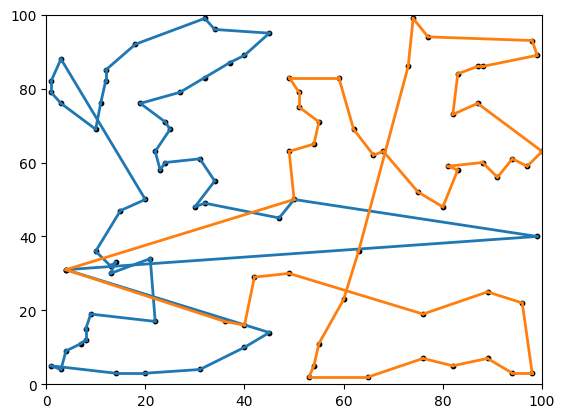

Best base solution :
  Max weights: 512
  Min weights: 381
  Sum weights: 893
  Difference max-min: 131


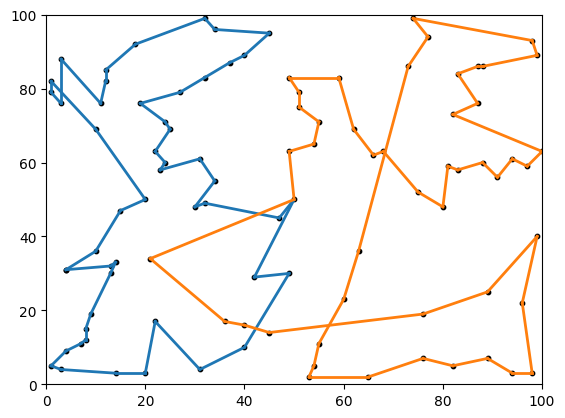

In [13]:
#########################
# Testing the Algorithm #
#########################

#model parameters
nbr_trucks = 2
num_cities = 99 # must be greater than 2*nbrTrucks+1

population_size = 500
num_generations = 500
mutation_rate   = 0.1

city_distances, coord_cities = generate_city_distances_rdm(num_cities)

print("Parameters :")
print("  Num_generations =", num_generations)
print("  population_size =", population_size)
print("  Mutation_rate =", mutation_rate)
                
time_start = datetime.datetime.now()

best_solution, best_solution_base = mtsp_genetic_algorithm(city_distances, population_size, num_generations, nbr_trucks, mutation_rate)

time_end = datetime.datetime.now()
delta = (time_end - time_start).total_seconds()

print("Execution time =", delta)
print("Best base solution : " )
draw_city_graph(coord_cities, best_solution_base)

total_weights = []

for route in best_solution:
    total_weight = 0
    
    for i in range(len(route) - 1):
        city1 = route[i]
        city2 = route[i + 1]
        total_weight += city_distances[city1][city2]
        
    total_weights.append(total_weight)


print("Best base solution :")
print("  Max weights:", max(total_weights))
print("  Min weights:", min(total_weights))
print("  Sum weights:", sum(total_weights))
print("  Difference max-min:", max(total_weights) - min(total_weights))
draw_city_graph(coord_cities, best_solution)
            


<u><b>Execution :</b></u><br>
Exemple d'exécution avec rat99 et 4 camions : <a name="exempleRat99"></a>

Best base solution : 


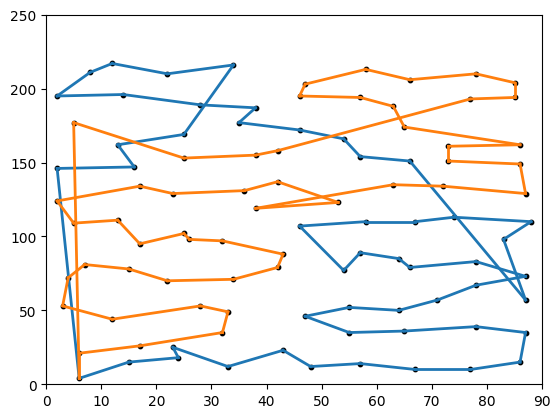

Best final solution : 


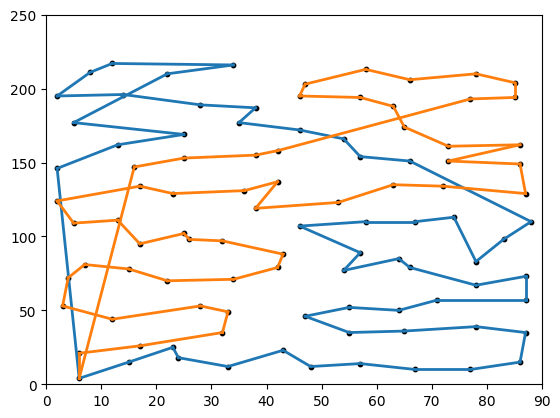

In [14]:
#########################
# Testing the Algorithm #
#########################

#model parameters
nbr_trucks = 2
filename = "rat99.tsp"

population_size = 500
num_generations = 500
mutation_rate   = 0.1

city_distances, coord_cities = generate_city_distances_file(filename)


best_solution, best_solution_base = mtsp_genetic_algorithm(city_distances, population_size, num_generations, nbr_trucks, mutation_rate)


print("Best base solution : ", )
draw_city_graph_rat99(coord_cities, best_solution_base)
print("Best final solution : " )
draw_city_graph_rat99(coord_cities, best_solution)
            


### <u><b>Execution de l'algorithme avec des instances prédéfinies et analyse des performances :</b></u>

##### <u><b>Rat99 avec 2, 3, 5 et 7 camions :</b></u>

Execution :

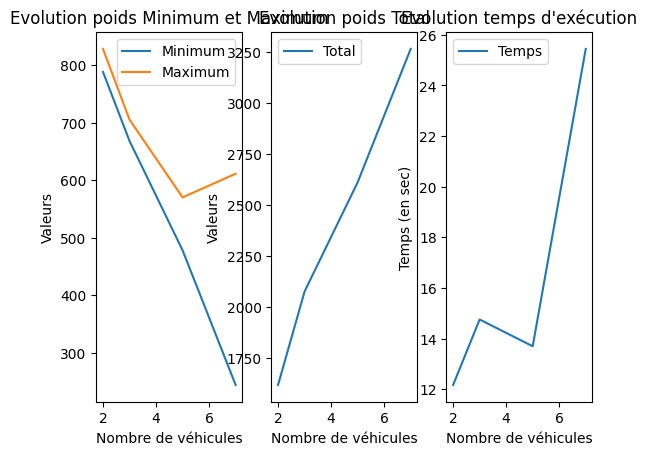

In [15]:
#########################
# Testing the Algorithm #
#########################

#model parameters
nbTruck = [2, 3, 5, 7]
filename = "rat99.tsp"

population_size = 500
num_generations = 500
mutation_rate   = 0.1

city_distances, coord_cities = generate_city_distances_file(filename)


exec_time   = []
max_weights = []
min_weights = []
sum_weights = []

for nbr_trucks in nbTruck:
              
    time_start = datetime.datetime.now()
    best_solution, best_solution_base = mtsp_genetic_algorithm(city_distances, population_size, num_generations, nbr_trucks, mutation_rate)
    time_end = datetime.datetime.now()
    delta = (time_end - time_start).total_seconds()
    exec_time.append(delta)

    total_weights = []
    
    for route in best_solution:
        total_weight = 0
        
        for i in range(len(route) - 1):
            city1 = route[i]
            city2 = route[i + 1]
            total_weight += city_distances[city1][city2]
            
        total_weights.append(total_weight)
    
    max_weights.append(max(total_weights))
    min_weights.append(min(total_weights))
    sum_weights.append(sum(total_weights))


                    
# Creation of minimum and maximum weight evolution graph
plt.subplot(1, 3, 1)
plt.plot(nbTruck, min_weights, label='Minimum')
plt.plot(nbTruck, max_weights, label='Maximum')

plt.xlabel('Nombre de véhicules')
plt.ylabel('Valeurs')
plt.title('Evolution poids Minimum et Maximum')
plt.legend()

# Creation of total weight evolution graph
plt.subplot(1, 3, 2)
plt.plot(nbTruck, sum_weights, label='Total')

plt.xlabel('Nombre de véhicules')
plt.ylabel('Valeurs')
plt.title('Evolution poids Total')
plt.legend()

# Creation of execution time evolution graph
plt.subplot(1, 3, 3)
plt.plot(nbTruck, exec_time, label='Temps')

plt.xlabel('Nombre de véhicules')
plt.ylabel('Temps (en sec)')
plt.title('Evolution temps d\'exécution')
plt.legend()


plt.show()       
            

Voici les résultat des performances de l'algorithme pour une instance bien définie (rat99), c'est résultats feront objet d'une critique dans la partie [Bilan](#bilan)

##### <u><b>Algorithme avec 2 000, 4 000, 6 000 et 8 000 camions, et un depot centré :</b></u>

MTSP solved


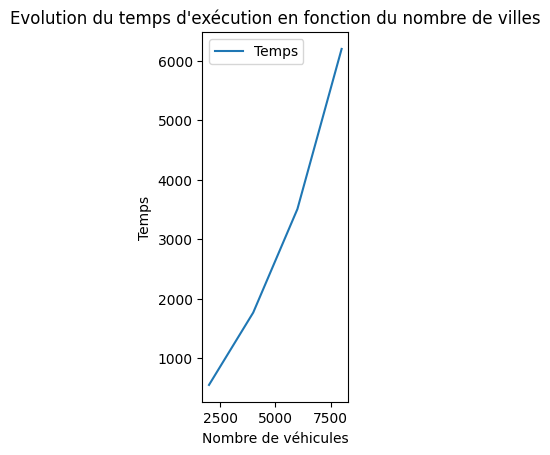

In [16]:
#########################
# Testing the Algorithm #
#########################

#  Model Parameters
nbrCamions = 10

# must be greater than 2*nbrTrucks+1
filenameList = ((2000,"instance/instance2K"), (4000,"instance/instance4K"), (6000,"instance/instance6K"),(8000,"instance/instance8K"))

population_size = 500
num_generations = 500
mutation_rate = 0.1

exec_time = []
instances = []

for filename in filenameList:
    city_distances, coord_cities = generate_city_distances_file(filename[1])  
      
    time_start = datetime.datetime.now()
    best_solution, best_solution_base = mtsp_genetic_algorithm(city_distances, population_size, num_generations, nbr_trucks, mutation_rate)
    time_end = datetime.datetime.now()
    delta = (time_end - time_start).total_seconds()
    
    exec_time.append(delta)
    instances.append(filename[0])
                
print("MTSP solved")
    
# Creation of minimum and maximum weight evolution graph
plt.subplot(1, 3, 1)
plt.plot(instances, exec_time, label='Temps')

plt.xlabel('Nombre de véhicules')
plt.ylabel('Temps')
plt.title('Evolution du temps d\'exécution en fonction du nombre de villes')
plt.legend()

plt.show()

### <u><b>Bilan et critique : </b></u>
A travers les tests ci-dessus on peut remarquer une tendance : <br>
<center><b>Plus le nombre d'instance augment, plus le temps d'execution ce rapproche de l'exponentiel</b></center><br>

La population de base cette base en partie des dérivés de la solution de l'algorithme du glouton. Cela fait que l'algorithme génétique apporte une faible amélioration. Cela se voit plus visuellement où dans la solution de base, il fait des itinéraires non "optimisé" est l'algorithme génétique règle cela.

On remarque que l'algorithme semble plutôt bien tenir le nombre de véhicules montant.

<u>Idée d'amélioration :</u><br>
Il serait intéressant d'appliquer une mutation différente. Plusieurs solutions possibles, la première seraient par exemple d'appliquer le recuit simulé. La seconde possibilité auquel je pense est non pas d'échanger 2 villes dans un individus, mais changers 2k villes pour k camions. On pourrait mélanger les 2 et faire en sorte que plus on avance dans les générations et moins on échange de villes dans un individu tout en gardant le taux de mutations fixe pour savoir le nombre d'individus à muter.